In [1]:
%matplotlib inline

In [2]:
from collections import defaultdict

In [3]:
from kid_readout.measurement.io import npy
from kid_readout.measurement import plot_basic
from kid_readout.analysis.resonator import lmfit_resonator

In [4]:
plot_directory = '/home/flanigan/temp/'

In [5]:
npd = npy.NumpyDirectory('/data/detectors/2017-03-07_185752_scan.npd/')  # 0.40 K

In [8]:
indices = [1, 3, 7, 12, 18, 23]  # From data-quality notebooks; these seem to contain resonances
attenuation_index = 1  # 0, 10, 20
measurements_per_lo_frequency = 6
suffixes = [index * measurements_per_lo_frequency + 2 * attenuation_index for index in indices]
suffixes

[8, 20, 44, 74, 110, 140]

In [10]:
sweeps = [npd.read('SweepArray{:d}'.format(suffix)) for suffix in suffixes]

# Nominal resonances

In [11]:
f_nominal = 1e9 * np.array([1.97, 2.38, 2.78, 3.19])

# Functions

In [75]:
def background(f, s21, amp_degree=4, phi_degree=4, weights=None, mask=None):
    if weights is None:
        weights = np.abs(s21)**2
    if mask is None:
        mask = np.ones(f.size, dtype=np.bool)
    weights *= mask
    amp_poly = np.polyfit(f, np.abs(s21), deg=amp_degree, w=weights)
    phi_poly = np.polyfit(f, np.unwrap(np.angle(s21)), deg=phi_degree, w=weights)
    return np.polyval(amp_poly, f) * np.exp(1j * np.polyval(phi_poly, f))

def remove_background(f, s21, amp_degree=4, phi_degree=4, weights=None, mask=None):
    return s21 / background(f, s21, amp_degree=amp_degree, phi_degree=phi_degree, weights=weights, mask=mask)

# Mask spikes

In [38]:
np.median(ks21.real)

0.019778576733845636

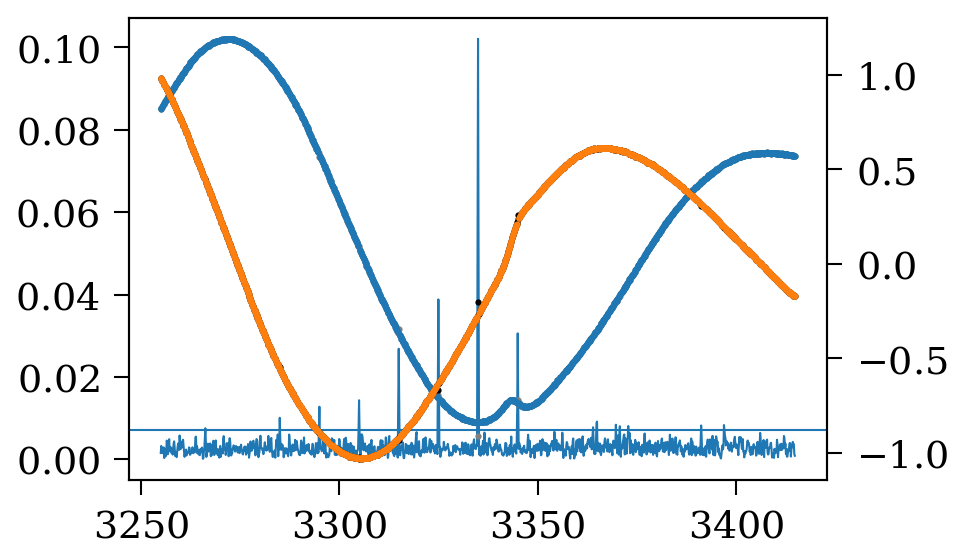

In [67]:
sweep = sweeps[5]
f = sweep.frequency_MHz
s21 = sweep.s21_point

kernel = np.array([-0.5, 1, -0.5])
ks21 = np.convolve(kernel, np.concatenate([s21[:1], s21, s21[-1:]]), mode='valid')
rms = np.std(np.abs(ks21))
#mask = (np.abs(ks21.real) < rms) & (np.abs(ks21.imag) < rms)
cut = np.mean(np.abs(ks21)) + rms
mask = np.abs(ks21) < cut
fig, ax = plt.subplots()
s_ax = ax.twinx()
ax.plot(f, np.abs(ks21))
ax.axhline(cut)
s_ax.plot(f, s21.imag, '.', color='gray')
s_ax.plot(f[mask], s21.imag[mask], '.')
s_ax.plot(f, s21.real, '.', color='black')
s_ax.plot(f[mask], s21.real[mask], '.')
#ax.axhline(rms, color='black')
#ax.axhline(-rms, color='black')

#ax.set_ylim(0, 3 * rms)

In [77]:
def spike_mask(s21, threshold=1):
    kernel = np.array([-0.5, 1, -0.5])
    ks21 = np.convolve(kernel, np.concatenate([s21[:1], s21, s21[-1:]]), mode='valid')
    rms = np.std(np.abs(ks21))
    mask = np.abs(ks21) < np.mean(np.abs(ks21)) + threshold * rms
    return mask

In [21]:
def fit_and_plot(sweep, ax, min_snr=0.5, Q=30000, num_linewidths=10, threshold=1):
    peaks = sweep.find_resonances(min_snr=min_snr, threshold=threshold)
    rs = [sweep.resonator(frequency=sweep.frequency[peak], width=num_linewidths * sweep.frequency.mean() / Q,
                       model=lmfit_resonator.LinearLossResonatorWithCable)
          for peak in peaks]
    rs = [r for r in rs if 
          1e-6 < r.loss_c and r.loss_c < 1e-2 and
          1e-6 < r.loss_i and r.loss_i < 1e-2
         ]
    for f in f_nominal:
        if sweep.frequency.min() < f and f < sweep.frequency.max():
            ax.axvline(1e-6 * f, color='green')
    ax.plot(sweep.frequency_MHz, np.abs(sweep.s21_point_foreground), color='gray')
    #ax.plot(sweep.frequency_MHz[peaks], np.abs(sweep.s21_point_foreground[peaks]), '.', color='green')
    for r in rs:
        plot_basic.resonator_amplitude(r, ax, normalize=False, decibels=False, three_ticks=False)
    return rs

# Raw data

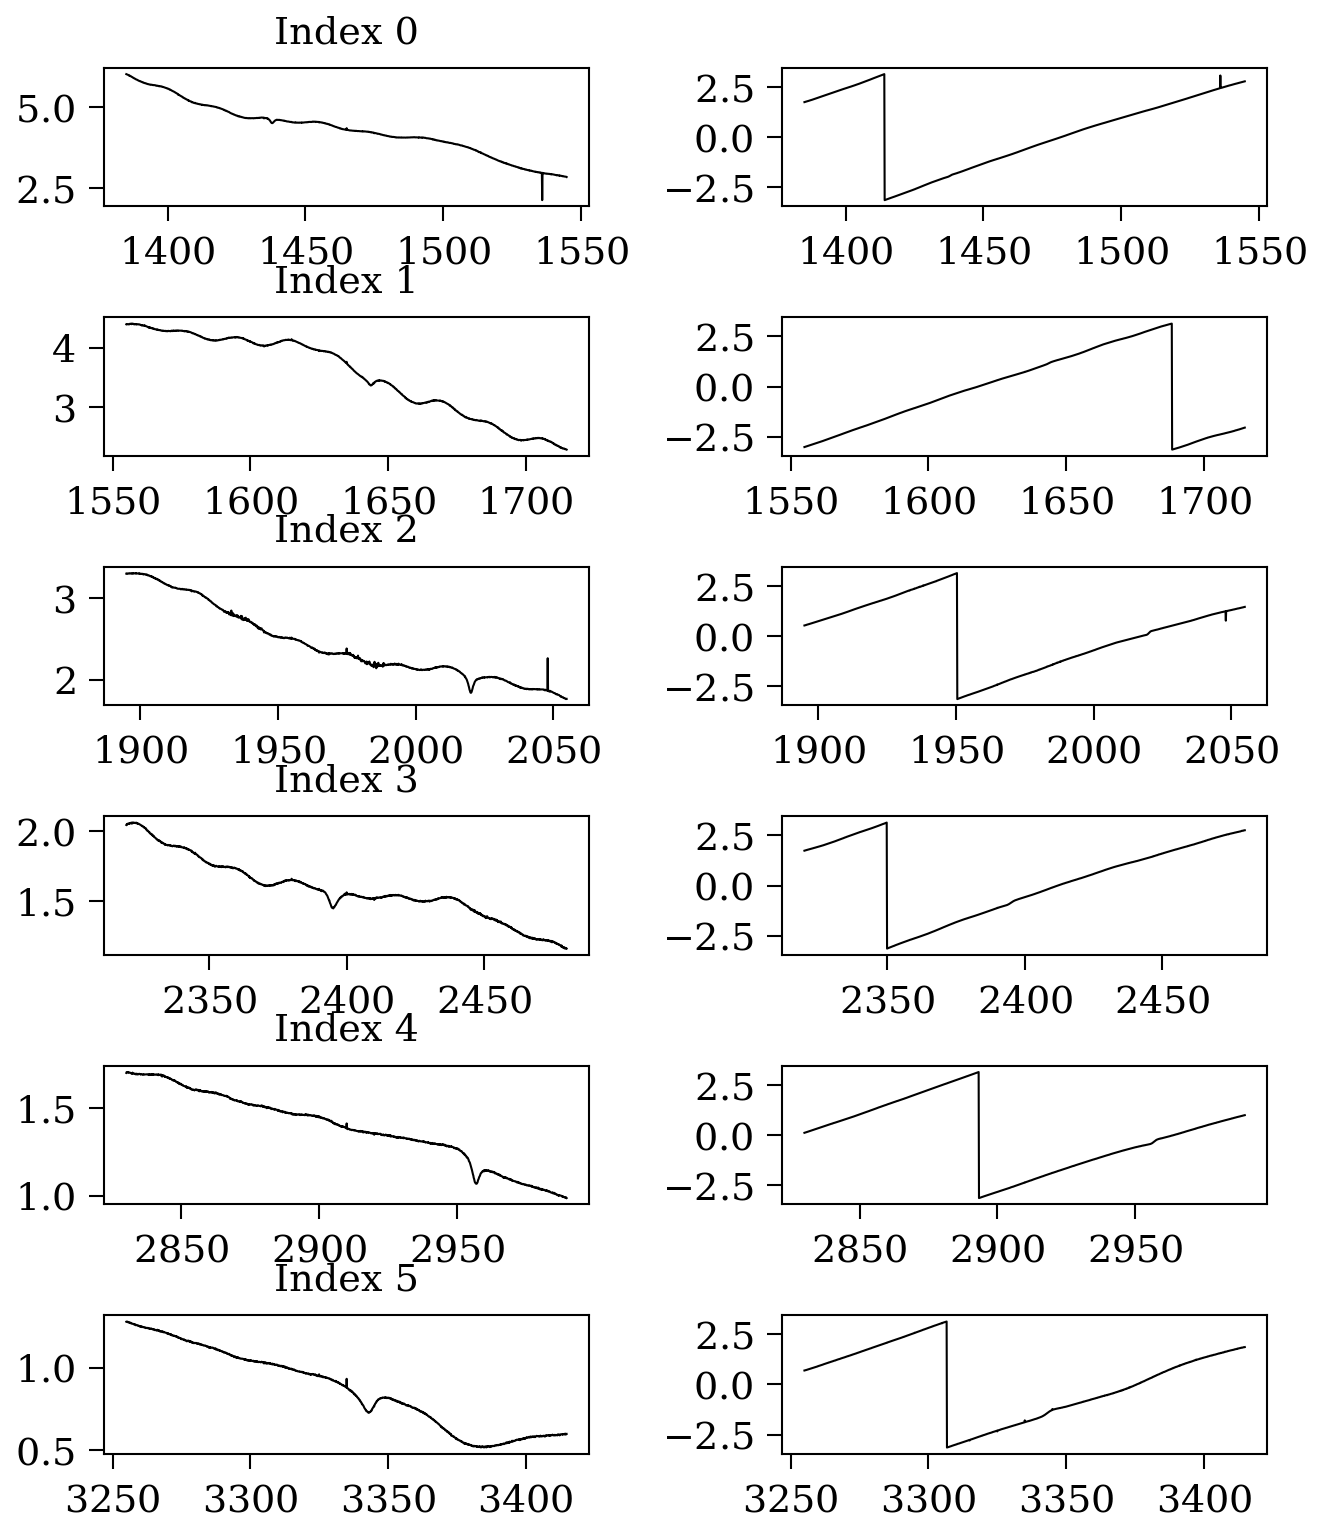

In [61]:
num_sweeps = len(sweeps)
fig, axes = plt.subplots(num_sweeps, 2, figsize=(5, num_sweeps), gridspec_kw={'wspace': 0.4, 'hspace': 0.8})
for index, (sweep, (amp_ax, phi_ax)) in enumerate(zip(sweeps, np.atleast_2d(axes))):
    amp_ax.set_title('Index {:d}'.format(index))
    s21 = sweep.s21_point
    amp_ax.plot(sweep.frequency_MHz, np.abs(s21), '-k')
    phi_ax.plot(sweep.frequency_MHz, np.angle(s21), '-k')

# Remove background and mask spikes

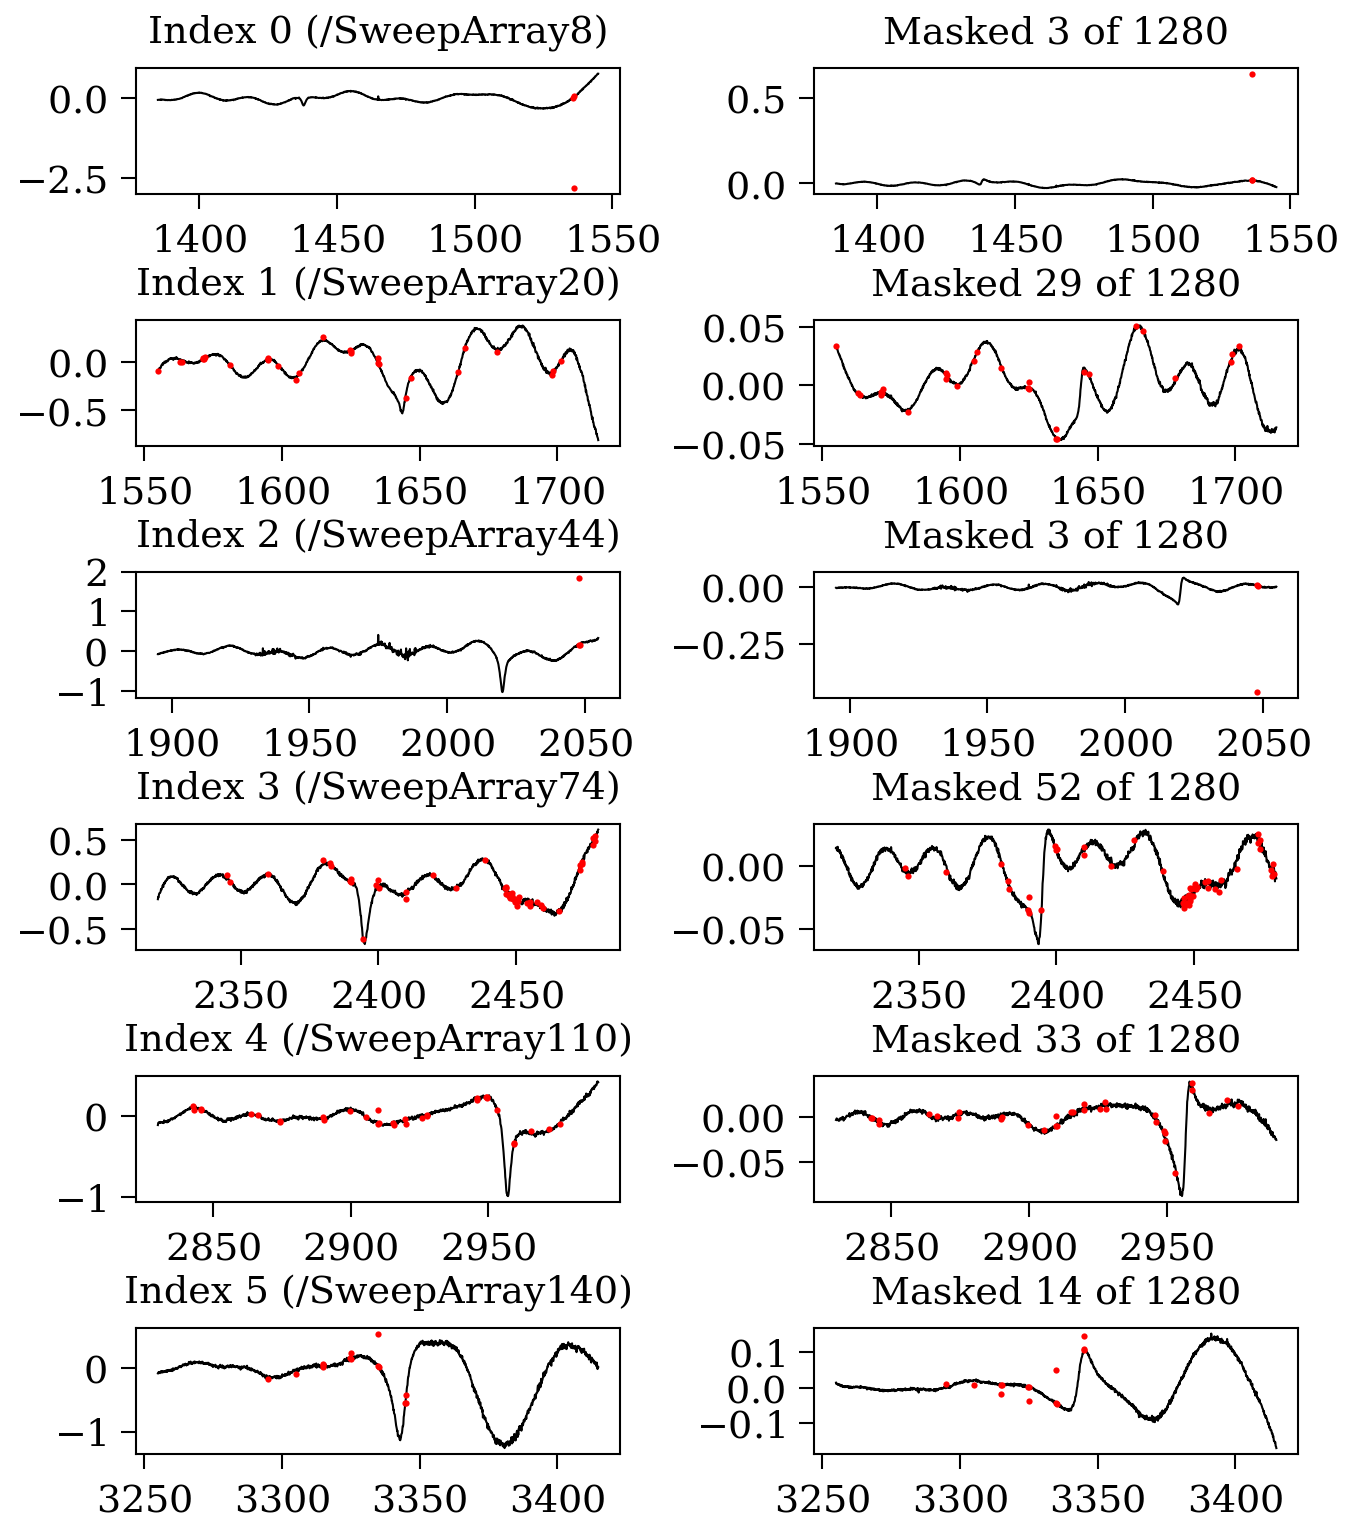

In [88]:
num_sweeps = len(sweeps)
fig, axes = plt.subplots(num_sweeps, 2, figsize=(5, num_sweeps), gridspec_kw={'wspace': 0.4, 'hspace': 1.0})
for index, (sweep, (amp_ax, phi_ax)) in enumerate(zip(sweeps, np.atleast_2d(axes))):
    amp_ax.set_title('Index {:d} ({})'.format(index, sweep._io_node_path))
    mask = spike_mask(sweep.s21_point, threshold=2)
    phi_ax.set_title('Masked {:d} of {:d}'.format(np.sum(np.logical_not(mask)), mask.size))
    s21 = remove_background(sweep.frequency, sweep.s21_point, mask=mask)
    amp_ax.plot(sweep.frequency_MHz[mask], 20 * np.log10(np.abs(s21[mask])), '-k')
    amp_ax.plot(sweep.frequency_MHz[np.logical_not(mask)],
                20 * np.log10(np.abs(s21[np.logical_not(mask)])), '.r')
    phi_ax.plot(sweep.frequency_MHz[mask], np.angle(s21[mask]), '-k')
    phi_ax.plot(sweep.frequency_MHz[np.logical_not(mask)],
                np.angle(s21[np.logical_not(mask)]), '.r')

/home/flanigan/readout/kid_readout/kid_readout/analysis/resonator/equations.py:86: RuntimeWarning: divide by zero encountered in true_divide
  (1 + (loss_i + 2j * x) / loss_c))
/home/flanigan/readout/kid_readout/kid_readout/analysis/resonator/equations.py:86: RuntimeWarning: invalid value encountered in true_divide
  (1 + (loss_i + 2j * x) / loss_c))


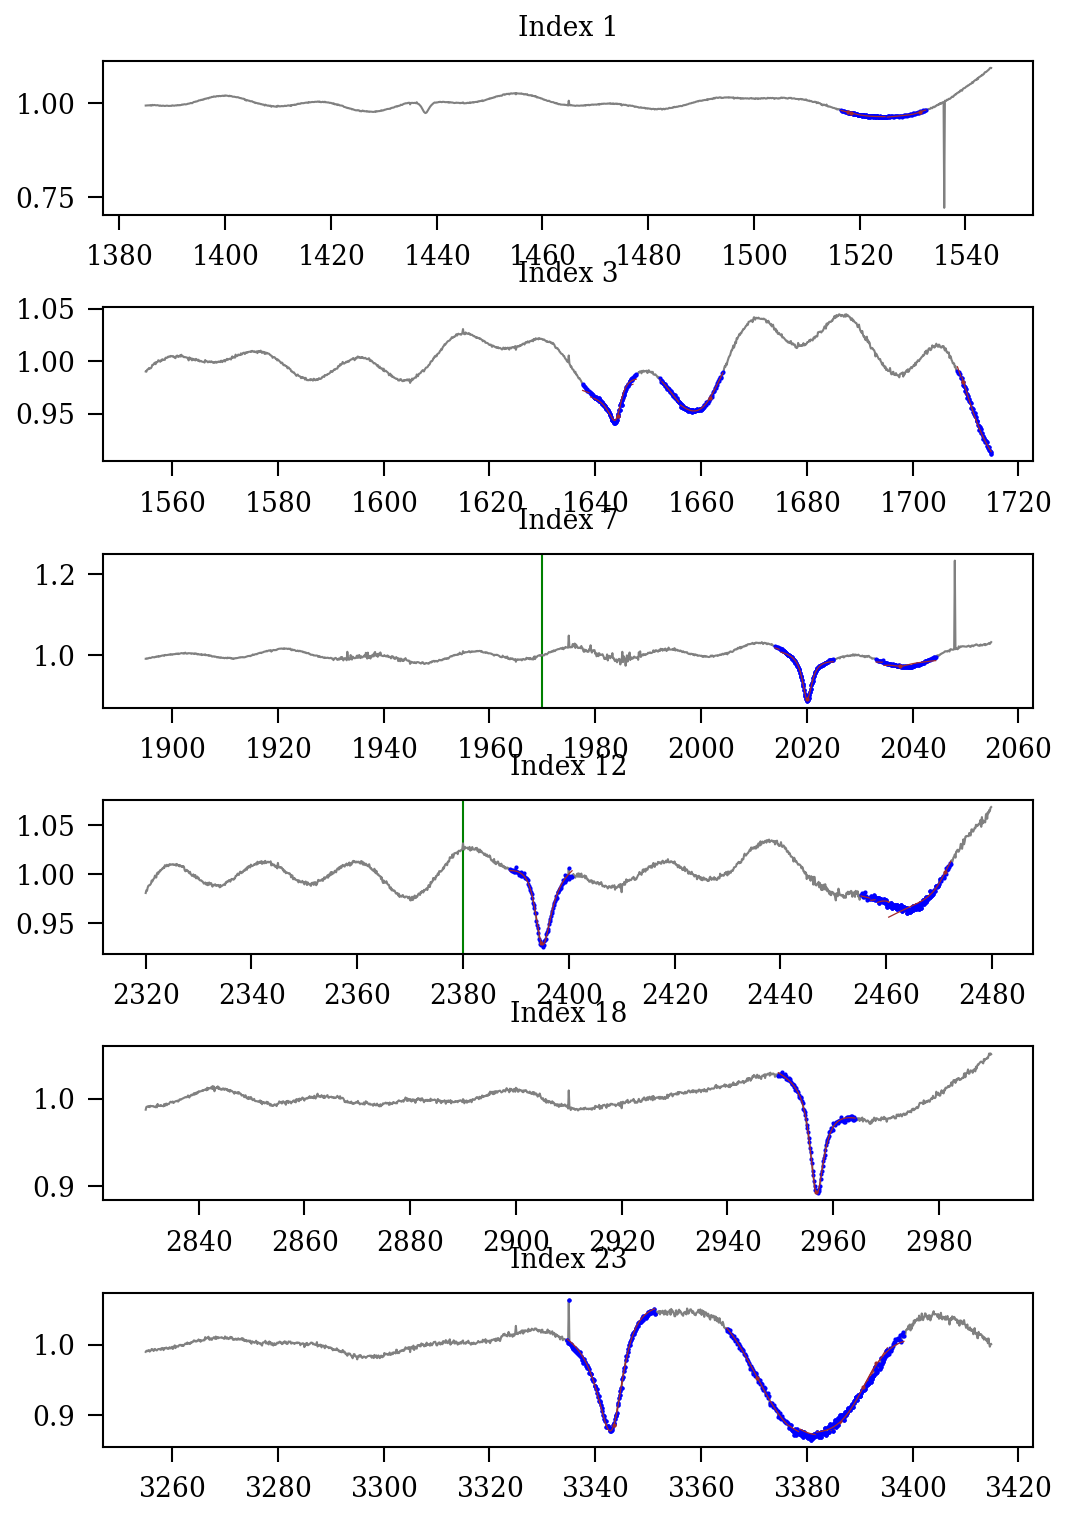

In [23]:
resonators = []
num_subplots = len(candidates)
fig, axes = plt.subplots(num_subplots, 1, figsize=(4, num_subplots), gridspec_kw={'hspace': 0.6})
for index, ax in zip(candidates, np.atleast_1d(axes).flatten()):
    sweep = sweeps[index]
    ax.tick_params(labelsize='xx-small')
    ax.set_title("Index {}".format(index), fontsize='xx-small')
    resonators.extend(fit_and_plot(sweep, ax, Q=3000, num_linewidths=15, min_snr=0.1, threshold=1.5))

In [28]:
s21 = sweeps[1].s21_point

In [ ]:
fig, ax = plt.subplots()
ax.plot()

In [24]:
[1e-6 * r.f_0 for r in resonators]

[1523.2035331822503,
 1517.875042703384,
 1518.3750002992128,
 1531.3892466326008,
 1644.0157961148748,
 1644.2334598480663,
 1644.2260591931706,
 1655.8679379211244,
 1656.5607635302092,
 1661.6684373327475,
 1710.2034443083023,
 1709.641756148018,
 2020.0616080423395,
 2020.0104915230738,
 2020.0071196708466,
 2037.1527503087727,
 2037.6690764148909,
 2394.8337343991416,
 2465.9339013356971,
 2463.4059294687504,
 2461.9833959475118,
 2471.2391143870595,
 2956.6987814311851,
 3343.5152247039891,
 3343.5152247039891,
 3370.6665965309385,
 3393.1249999867132,
 3393.2849651853626,
 3390.7168096060632]

In [25]:
[r.Q_i for r in resonators]

[151.16637256076856,
 100.05835057669243,
 119.56293146448643,
 319.55104604766876,
 779.13644683414384,
 617.66688083004158,
 545.83096602168803,
 108.88178352530039,
 107.16482613371804,
 118.83354004330849,
 126.99653390057622,
 111.7279468737962,
 955.70817002800322,
 977.14575750342226,
 978.11333005616495,
 462.51297814165702,
 627.65172649060366,
 672.8723773793721,
 632.93247929144638,
 271.65952840413377,
 287.5044321334143,
 284.2074012155922,
 1000.2938286146514,
 607.84201415329176,
 607.84201415329176,
 118.9629543063303,
 115.75638364354874,
 118.09162301949536,
 204.41245090468291]

In [26]:
[r.Q_e for r in resonators]

[(996.72761678633924+9967.0948381246053j),
 (2110.275783447441-2903.4865340934575j),
 (2385.7961920363441-5060.9062998115223j),
 (3748.493119114692+37484.835137217364j),
 (23411.639574681405+12235.789599527354j),
 (13242.676012684205+11144.63174413946j),
 (10951.598639216139+8512.1778667803628j),
 (760.66138927825637-1039.3786878112096j),
 (907.65572306812373-795.27564131671977j),
 (1027.9706075175945+885.71487851568475j),
 (222.21817130476344-2222.1711089305395j),
 (134.40943071622638-1344.0943050780043j),
 (7655.2649765330516-185.33214736637274j),
 (7903.2540137817587-688.9634664961975j),
 (7903.4225234892501-725.21619535033744j),
 (28762.545091860407-25497.385459426114j),
 (83106.420639593111-23465.694505710671j),
 (6931.7365858168705-2094.0170158826541j),
 (5862.9694827324529+42332.417818569324j),
 (7523.0309534408498-4822.7716376456247j),
 (1656.6732321376055-8639.1059597623935j),
 (917.6792246263567+9176.7915607632222j),
 (7328.4413729689231-1583.2074159297626j),
 (2811.313020192

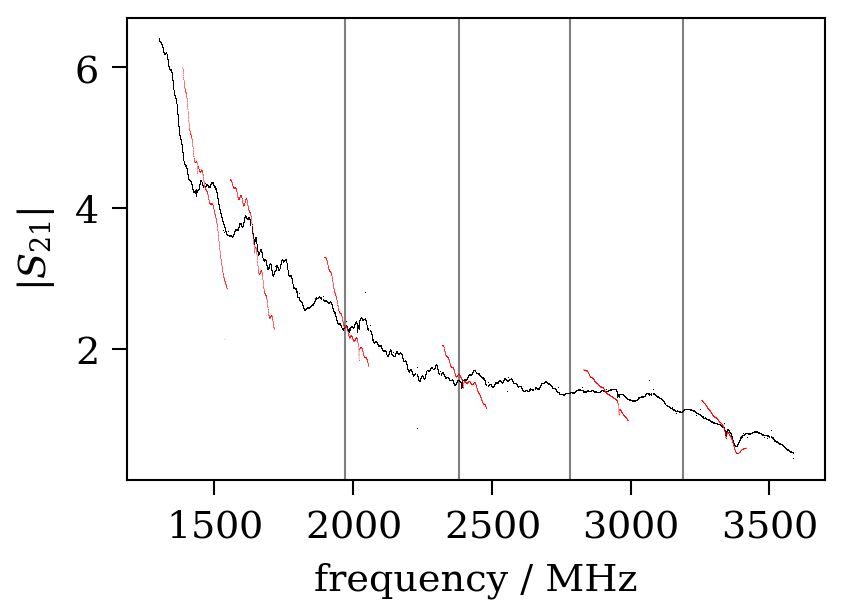

In [27]:
fig, ax = plt.subplots()
ax.set_xlabel('frequency / MHz')
ax.set_ylabel('$|S_{21}|$')
for f in f_nominal:
    ax.axvline(1e-6 * f, color='gray')
ax.plot(1e-6 * frequency, np.abs(amplitude), ',k')
for index in candidates:
    sweep = sweeps[index]
    ax.plot(1e-6 * sweep.frequency, np.abs(sweep.s21_point) - 0.01, ',r', alpha=0.2)